In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg
from scipy.ndimage.filters import gaussian_filter1d

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
### Load behavior 

### standard ###
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/20221202_master_X_noYclip.npy"
X_beh = np.load(file)
print(X_beh.shape)

### ACCEL ###
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/20230117_master_X_accel_noclip.npy"
X_beh_accel = np.load(file)
print(X_beh_accel.shape)

(49, 9, 2000, 3384)
(49, 9, 1000, 3384)


In [ ]:
X_beh.shape

(1500, 1600)

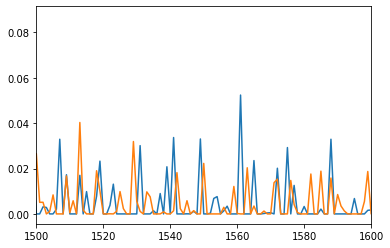

In [15]:
plt.plot(X_beh_accel[20,0,250,:])
plt.plot(X_beh_accel[20,0,500,:])

plt.xlim(1500,1600)

In [5]:
# the main thing to deal with now is the z-depth
# for a given supercluster, i need to know the original median z-depth for each fly
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


In [6]:
superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

(256, 128, 49)

In [7]:
original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


In [23]:
def bin_2D(pc, num_bins_x, num_bins_y, idx_x ,idx_y, X_accel, Y_accel):
    #"PC" is just a holdover
    pc_binned = []
    accel_X_binned = []
    accel_Y_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            accel_X_binned.append(np.mean((pc*X_accel)[mask]))
            accel_Y_binned.append(np.mean((pc*Y_accel)[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    accel_X_binned = np.flip(np.reshape(accel_X_binned,(num_bins_x, num_bins_y)).T,0)
    accel_Y_binned = np.flip(np.reshape(accel_Y_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'accel_X_binned': accel_X_binned,
                  'accel_Y_binned': accel_Y_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def bin_2D_plot(x_data, y_data, value_data, X_accel, Y_accel, 
                num_bins_x, num_bins_y, start_x, end_x, start_y, end_y, min_num_samples):
    # Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)
    
    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins_x), np.digitize(y_data,bins_y)

    test = bin_2D(value_data, num_bins_x, num_bins_y, idx_x ,idx_y, X_accel, Y_accel)
    
    # Hide bins containing too few data points
    test['pc_binned'][np.where(test['pc_count']<=min_num_samples)] = 0
    return test['pc_binned'], test['accel_X_binned'], test['accel_Y_binned']

In [43]:
cluster_ = 150#77#21

all_2d_hists = []
all_2d_hists_accel_X = []
all_2d_hists_accel_Y = []
for cluster in [cluster_,cluster_+250]:
    
    Xs_new = []
    for fly in range(9):
        Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
    Xs_new = np.asarray(Xs_new)
    beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))
    
    ######## Repeat for acceleration!
    Xs_new = []
    for fly in range(9):
        Xs_new.append(X_beh_accel[original_z_depth[fly,cluster],fly,:,:])
    Xs_new = np.asarray(Xs_new)
    accel_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))
    ##########

    for j,shift in tqdm.tqdm(enumerate(np.arange(-200,200,1))):
        Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
        Y_var /= np.std(Y_var)

        X_var = beh_cluster[250+shift,:]
        X_var /= np.std(X_var)
        
        ### Prep accel!
        Y_accel = accel_cluster[750+shift,:]
        X_accel = accel_cluster[250+shift,:]

        start_x=-2; end_x=6; start_y=-4; end_y=4

        signal = supercluster_signals[cluster,:]
        fictrac_2d, accel_X_2d, accel_Y_2d = bin_2D_plot(X_var, Y_var, signal, X_accel, Y_accel,
                                         num_bins_x=25, num_bins_y=25,
                                         start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                         min_num_samples=9)

        fictrac_2d[-1,:] = 0
        all_2d_hists.append(fictrac_2d)
        accel_X_2d[-1,:] = 0
        all_2d_hists_accel_X.append(accel_X_2d)
        accel_Y_2d[-1,:] = 0
        all_2d_hists_accel_Y.append(accel_Y_2d)
        
all_2d_hists = np.reshape(np.asarray(all_2d_hists),(2,400,25,25))
print(all_2d_hists.shape)

all_2d_hists_accel_X = np.reshape(np.asarray(all_2d_hists_accel_X),(2,400,25,25))
all_2d_hists_accel_Y = np.reshape(np.asarray(all_2d_hists_accel_Y),(2,400,25,25))

400it [00:33, 12.01it/s]
400it [00:33, 12.00it/s]

(2, 400, 25, 25)


In [44]:
all_2d_hists = all_2d_hists[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
all_2d_hists_smooth = gaussian_filter1d(all_2d_hists,sigma=3,axis=1)

In [45]:
all_2d_hists_accel_X = all_2d_hists_accel_X[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
all_2d_hists_accel_X_smooth = gaussian_filter1d(all_2d_hists_accel_X,sigma=3,axis=1)

all_2d_hists_accel_Y = all_2d_hists_accel_Y[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
all_2d_hists_accel_Y_smooth = gaussian_filter1d(all_2d_hists_accel_Y,sigma=3,axis=1)

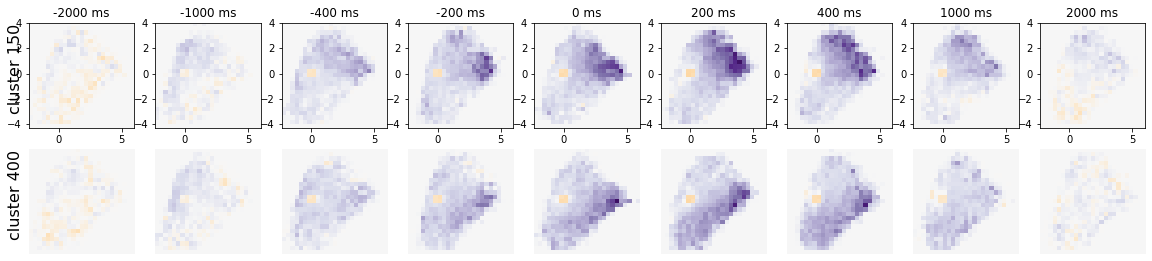

In [46]:
plt.figure(figsize=(20,10))
vmax = np.max(all_2d_hists_smooth)
tps = [100,150,180,190,200,210,220,250,300]

for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1)
    plt.title(F"{(tp-200)*20} ms")
    plt.imshow(all_2d_hists_smooth[0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    #plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)
    
for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1+len(tps))
    plt.imshow(all_2d_hists_smooth[1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)
    
plt.subplots_adjust(hspace=-.7)

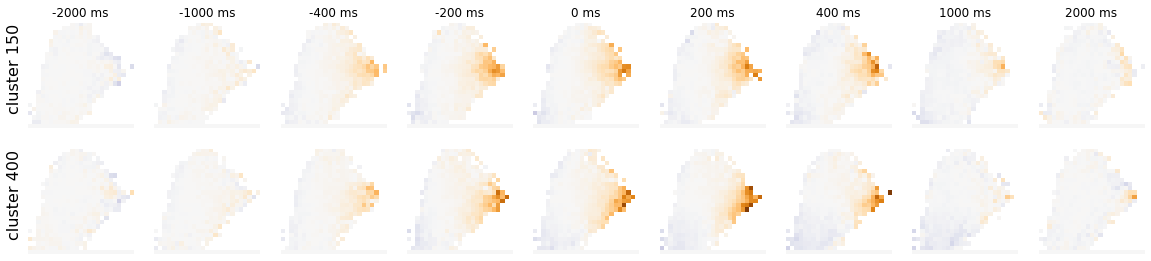

In [47]:
plt.figure(figsize=(20,10))
vmax = np.max(np.nan_to_num(all_2d_hists_accel_X_smooth))
tps = [100,150,180,190,200,210,220,250,300]

for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1)
    plt.title(F"{(tp-200)*20} ms")
    plt.imshow(all_2d_hists_accel_X_smooth[0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)
    
for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1+len(tps))
    plt.imshow(all_2d_hists_accel_X_smooth[1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)
    
plt.subplots_adjust(hspace=-.7)

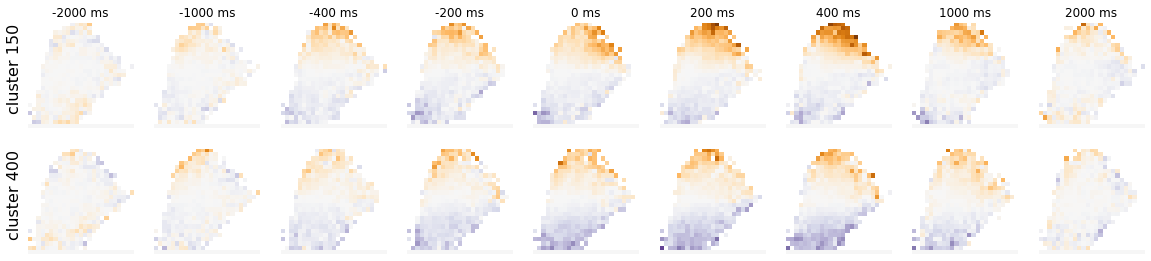

In [48]:
plt.figure(figsize=(20,10))
vmax = np.max(np.nan_to_num(all_2d_hists_accel_Y_smooth))
tps = [100,150,180,190,200,210,220,250,300]

for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1)
    plt.title(F"{(tp-200)*20} ms")
    plt.imshow(all_2d_hists_accel_Y_smooth[0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)
    
for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1+len(tps))
    plt.imshow(all_2d_hists_accel_Y_smooth[1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)
    
plt.subplots_adjust(hspace=-.7)

# loop version

In [ ]:
all_3d_hists_accel_X = []
all_3d_hists_accel_Y = []

for cluster_ in range(251):
    print(cluster_)

    all_2d_hists = []
    all_2d_hists_accel_X = []
    all_2d_hists_accel_Y = []
    for cluster in [cluster_,cluster_+250]:

        Xs_new = []
        for fly in range(9):
            Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
        Xs_new = np.asarray(Xs_new)
        beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

        ######## Repeat for acceleration!
        Xs_new = []
        for fly in range(9):
            Xs_new.append(X_beh_accel[original_z_depth[fly,cluster],fly,:,:])
        Xs_new = np.asarray(Xs_new)
        accel_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))
        ##########

        for j,shift in enumerate(np.arange(-200,200,1)):
            Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
            Y_var /= np.std(Y_var)

            X_var = beh_cluster[250+shift,:]
            X_var /= np.std(X_var)

            ### Prep accel!
            Y_accel = accel_cluster[750+shift,:]
            X_accel = accel_cluster[250+shift,:]

            start_x=-2; end_x=6; start_y=-4; end_y=4

            signal = supercluster_signals[cluster,:]
            fictrac_2d, accel_X_2d, accel_Y_2d = bin_2D_plot(X_var, Y_var, signal, X_accel, Y_accel,
                                             num_bins_x=25, num_bins_y=25,
                                             start_x=start_x, end_x=end_x, start_y=start_y, end_y=end_y,
                                             min_num_samples=9)

            fictrac_2d[-1,:] = 0
            all_2d_hists.append(fictrac_2d)
            accel_X_2d[-1,:] = 0
            all_2d_hists_accel_X.append(accel_X_2d)
            accel_Y_2d[-1,:] = 0
            all_2d_hists_accel_Y.append(accel_Y_2d)

    all_2d_hists = np.reshape(np.asarray(all_2d_hists),(2,400,25,25))
    print(all_2d_hists.shape)

    all_2d_hists_accel_X = np.reshape(np.asarray(all_2d_hists_accel_X),(2,400,25,25))
    all_2d_hists_accel_Y = np.reshape(np.asarray(all_2d_hists_accel_Y),(2,400,25,25))
    all_2d_hists_accel_X = all_2d_hists_accel_X[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
    all_2d_hists_accel_X_smooth = gaussian_filter1d(all_2d_hists_accel_X,sigma=3,axis=1)
    all_2d_hists_accel_Y = all_2d_hists_accel_Y[:,::-1,:,:] ### FLIP TIME TO BE "FORWARD"
    all_2d_hists_accel_Y_smooth = gaussian_filter1d(all_2d_hists_accel_Y,sigma=3,axis=1)
    
    all_3d_hists_accel_X.append(all_2d_hists_accel_X_smooth)
    all_3d_hists_accel_Y.append(all_2d_hists_accel_Y_smooth)
    
file = os.path.join(cluster_dir, '20230117_3d_hists_accel_X')
np.save(file, np.asarray(all_3d_hists_accel_X))
file = os.path.join(cluster_dir, '20230117_3d_hists_accel_Y')
np.save(file, np.asarray(all_3d_hists_accel_X))

0
(2, 400, 25, 25)
1
(2, 400, 25, 25)
2
(2, 400, 25, 25)
88
(2, 400, 25, 25)
89
(2, 400, 25, 25)
90
(2, 400, 25, 25)
91
(2, 400, 25, 25)
92
(2, 400, 25, 25)
93
(2, 400, 25, 25)
94
(2, 400, 25, 25)
95
(2, 400, 25, 25)
96
(2, 400, 25, 25)
97
(2, 400, 25, 25)
98
(2, 400, 25, 25)
99
(2, 400, 25, 25)
100
(2, 400, 25, 25)
101
(2, 400, 25, 25)
102
(2, 400, 25, 25)
103
(2, 400, 25, 25)
104
(2, 400, 25, 25)
105
(2, 400, 25, 25)
106
(2, 400, 25, 25)
107
(2, 400, 25, 25)
108
(2, 400, 25, 25)
109
(2, 400, 25, 25)
110
(2, 400, 25, 25)
111
(2, 400, 25, 25)
112
(2, 400, 25, 25)
113
(2, 400, 25, 25)
114
(2, 400, 25, 25)
115
(2, 400, 25, 25)
116
(2, 400, 25, 25)
117
(2, 400, 25, 25)
118
(2, 400, 25, 25)
119


# Load loop

In [3]:
file = os.path.join(cluster_dir, '20230117_3d_hists_accel_X.npy')
accel_X = np.load(file)
file = os.path.join(cluster_dir, '20230117_3d_hists_accel_Y.npy')
accel_Y = np.load(file)

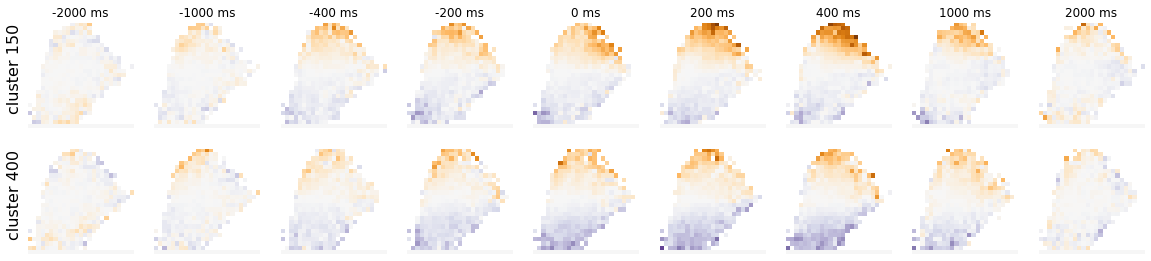

In [6]:
cluster_ = 150

plt.figure(figsize=(20,10))
vmax = np.max(np.nan_to_num(accel_Y[cluster_,0,:,:,:]))
tps = [100,150,180,190,200,210,220,250,300]

for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1)
    plt.title(F"{(tp-200)*20} ms")
    plt.imshow(accel_Y[cluster_,0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)
    
for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1+len(tps))
    plt.imshow(accel_Y[cluster_,1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)
    
plt.subplots_adjust(hspace=-.7)

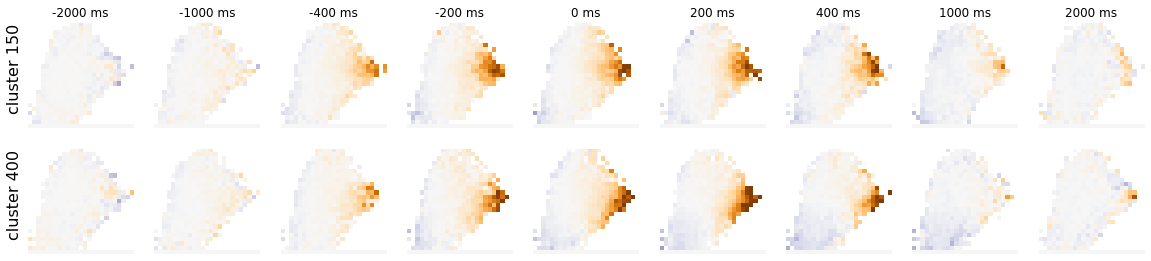

In [7]:
plt.figure(figsize=(20,10))
vmax = np.max(np.nan_to_num(accel_X[cluster_,0,:,:,:]))
tps = [100,150,180,190,200,210,220,250,300]

for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1)
    plt.title(F"{(tp-200)*20} ms")
    plt.imshow(accel_X[cluster_,0,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=16)
    
for j,tp in enumerate(tps):
    plt.subplot(2,len(tps),j+1+len(tps))
    plt.imshow(accel_X[cluster_,1,tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
    plt.axis('off')
    if j==0:
        plt.text(-4,-3,F"cluster {cluster_+250}",rotation=90,fontsize=16)
    
plt.subplots_adjust(hspace=-.7)